In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import brier_score_loss

In [2]:
pkl_file = open('colab_pkls/t31_pred_np.pkl', 'rb')
t31_pred_np = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('colab_pkls/ucpd_vol.pkl', 'rb')
ucpd_vol = pickle.load(pkl_file)
pkl_file.close()

# features = ['gid','best', 'low',  'high', 'log_best', 'log_low', 'log_high'] # ucpd_vol[:,:,:,0:6]

In [3]:
def my_sigmoid(x):
    s  = 1/(1 + np.e **(-x))
    return(s)

t31_pred_np_mean = t31_pred_np.mean(axis=0)
t31_pred_np_std = t31_pred_np.std(axis=0)
t31_pred_np_mean = np.maximum(t31_pred_np_mean,0) # relu to prevent sub zeroes.. it does almost no differnece when you have the variational layar.

y_var = t31_pred_np_std[0,0,:,:].reshape(360*720)
y_score = t31_pred_np_mean.reshape(360*720)
y_true = ucpd_vol[30,:,:,4].reshape(360*720)
gid = ucpd_vol[30,:,:,0].reshape(360*720)

df = pd.DataFrame({'gid': gid, 'log_best' : y_true, 'pred_log_best_mean' : y_score, 'pred_log_best_var': y_var})
print(df.shape)

(259200, 4)


In [4]:
df.head()

,gid,log_best,pred_log_best_mean,pred_log_best_var
0,258481.0,0.0,0.006762,0.004776
1,258482.0,0.0,0.008764,0.005239
2,258483.0,0.0,0.010574,0.005216
3,258484.0,0.0,0.009382,0.006226
4,258485.0,0.0,0.009295,0.005774


In [10]:
prio_grid = gpd.read_file("zip://priogrid_shapefiles.zip")

prio_gwcc = pd.read_csv('PRIO_grid_gwcc.csv')
# prio_gwcc = prio_dynamic.sort_values(['year', 'ycoord', 'xcoord'], ascending = [True, False, True]) # not sure i matters when you merge on gid.. Og du har desuden kun 2014 med...

# remove all years (only 2014)
prio_gwcc = prio_gwcc[['gid', 'gwno']]

In [11]:
prio_gwcc.columns

Index(['gid', 'gwno'], dtype='object')

In [13]:
# one year, merge on gid.
grid_gwcc = pd.merge(prio_grid, prio_gwcc, how = 'inner', on = ['gid'])
remerged = pd.merge(grid_gwcc, df, how = 'outer', on = ['gid'])

In [14]:
remerged.columns

Index(['gid', 'xcoord', 'ycoord', 'col', 'row', 'geometry', 'gwno', 'log_best',
       'pred_log_best_mean', 'pred_log_best_var'],
      dtype='object')

In [23]:
remerged['log_best_diff'] = remerged['log_best'] - remerged['pred_log_best_mean']
remerged['log_best_abs_diff'] = np.absolute(remerged['log_best_diff']) 

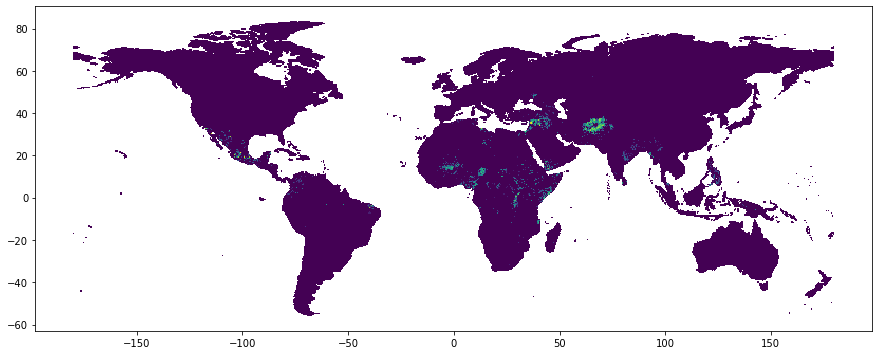

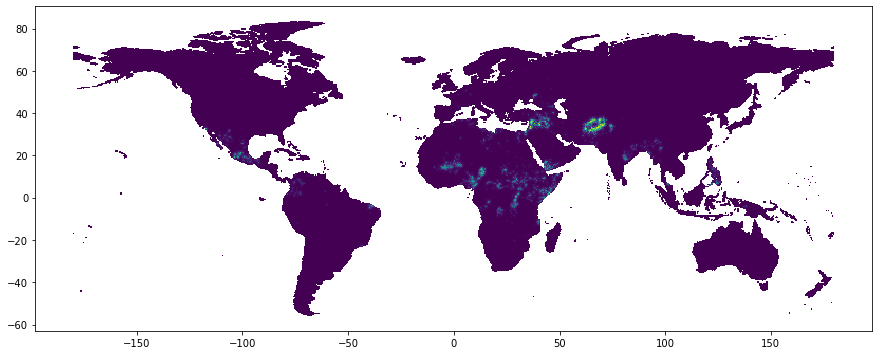

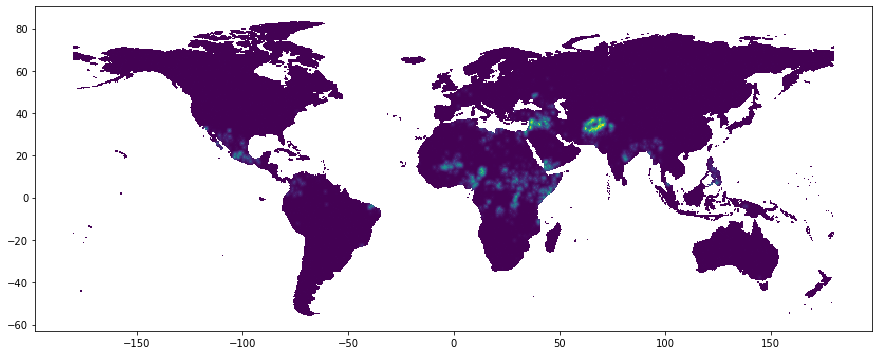

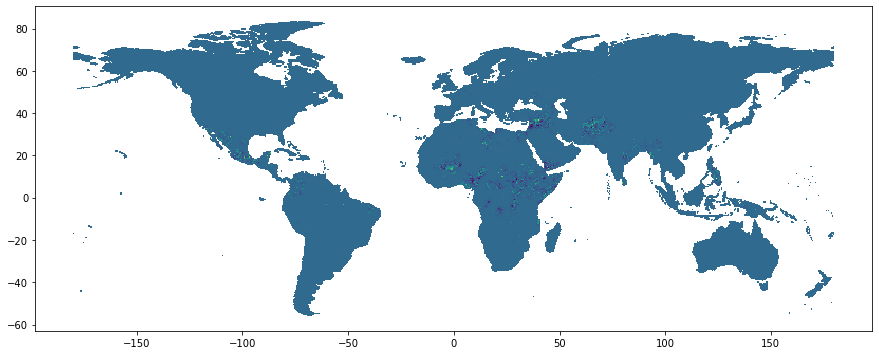

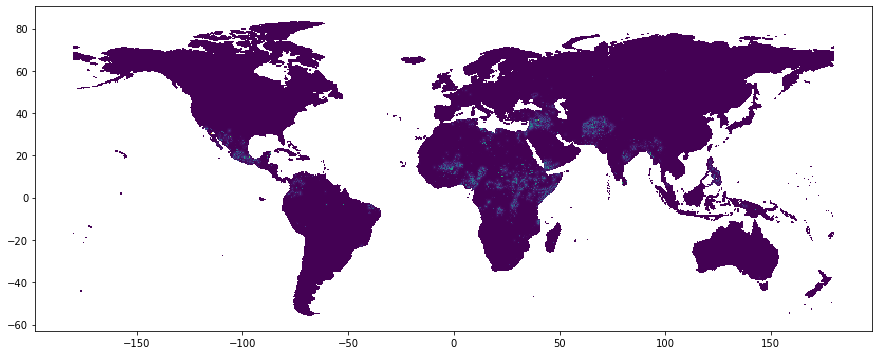

In [24]:
remerged.plot(column='log_best', figsize=(15, 15))
plt.show()

remerged.plot(column='pred_log_best_mean', figsize=(15, 15))
plt.show()

remerged.plot(column='pred_log_best_var', figsize=(15, 15))
plt.show()

remerged.plot(column='log_best_diff', figsize=(15, 15))
plt.show()

remerged.plot(column='log_best_abs_diff', figsize=(15, 15))
plt.show()

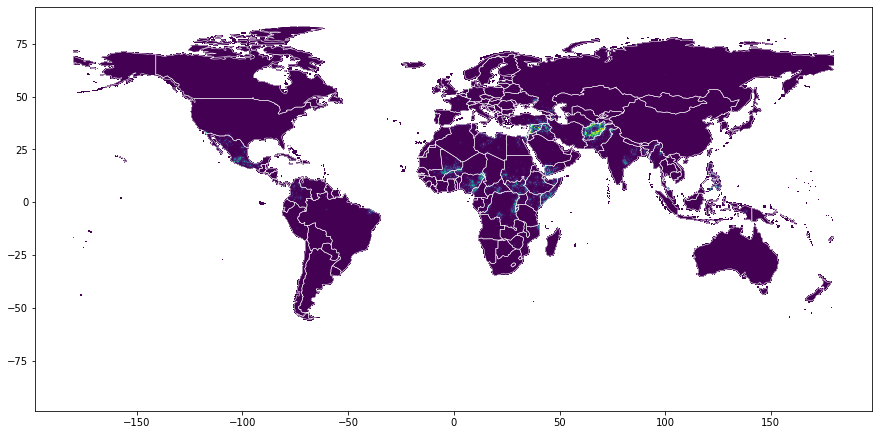

In [38]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base0 = world.boundary.plot(edgecolor='white', linewidth = 0.5, figsize = (15, 15))

remerged.plot(column='pred_log_best_mean', figsize=(15, 15),  ax = base0)
plt.show()

plt.show()
# cool but we do not need it now.

In [25]:
new_df = pd.DataFrame(remerged.drop('geometry', axis =1)) #

In [28]:
type(new_df)

pandas.core.frame.DataFrame

In [40]:
file_name = "colab_pkls/new_df.pkl"
output = open(file_name, 'wb')
pickle.dump(new_df, output)
output.close()